# Confidence analysis

#### Confronto tra la confidence di OpenFace e il *concordance correlation coefficient* tra i landmark dei due tool.

In [1]:
%matplotlib inline

import os
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from scipy.signal import find_peaks, peak_widths
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing

In [2]:
FACE_MESH = pd.read_csv('../faceMesh/face_mesh.csv')

def landmarks_mapper(video: str):
    
    OPENFACE_LANDMARKS = [i for i in range(17, 68)]
    OPENFACE_DIR = '../openFace/train/processed/'
    MEDIAPIPE_DIR = '../mediaPipe/train/processed/'
        
    of_df = pd.read_csv(OPENFACE_DIR + video + '.csv')
    mp_df = pd.read_csv(MEDIAPIPE_DIR + video + '.csv')
    
    final_df = of_df['frame'] # initialize the final dataframe
    for i, landmark in enumerate(OPENFACE_LANDMARKS):

        mask = (FACE_MESH['openFace_landmark'] == landmark) # group the mediapipe landmarks by the openface landmark

        tmp1_df = of_df[[f'x_{landmark}', f'y_{landmark}']] # select the columns from the openface dataframe
        tmp1_df.columns = [f'openface_x_{landmark}', f'openface_y_{landmark}'] # rename the columns
        
        mediaPipe_landmarks_X = ['x_'+str(ID) for ID in FACE_MESH[mask].id] # collect the X coordinate
        mediaPipe_landmarks_Y = ['y_'+str(ID) for ID in FACE_MESH[mask].id] # collect the Y coordinate
        
        tmp2_df = pd.DataFrame({f'mediapipe_x_{landmark}':mp_df[mediaPipe_landmarks_X].mean(axis=1),
                                f'mediapipe_y_{landmark}':mp_df[mediaPipe_landmarks_Y].mean(axis=1)})
        
        final_df = pd.concat([final_df, tmp1_df, tmp2_df], axis=1)
        
    return final_df

In [3]:
def windowize(df: pd.DataFrame, window_size: float):
    """
    Returns an array of dataframes of the windowized video
    """
    LANDMARKS = [f'x_{i}' for i in range(68)] + [f'y_{i}' for i in range(68)]
    n_frames = round(window_size*24) # 24 frames per second
    n_dataFrames = df.frame.size-n_frames+1
    array_df = np.ndarray(shape=n_dataFrames, dtype=pd.DataFrame)
    for i in range(n_dataFrames):
        array_df[i] = df.iloc[i:i+n_frames]
    
    return array_df

In [4]:
def pearson(df: pd.DataFrame):
    
    lndmk_pearson = []
    for i in range(17, 68):
        
        x_pearson = pearsonr(df[f'openface_x_{i}'].to_numpy(), df[f'mediapipe_x_{i}'].to_numpy())[0]
        y_pearson = pearsonr(df[f'openface_y_{i}'].to_numpy(), df[f'mediapipe_y_{i}'].to_numpy())[0]
        lndmk_pearson.append((x_pearson+y_pearson)/2)
    
    video_pearson = np.mean(lndmk_pearson)
    
    return video_pearson

In [5]:
def mse(df: pd.DataFrame):
    
    lndmk_mse = []
    for i in range(17, 68):
        
        x_mse = mean_squared_error(df[f'mediapipe_x_{i}'].to_numpy(), df[f'openface_x_{i}'].to_numpy())
        y_mse = mean_squared_error(df[f'mediapipe_y_{i}'].to_numpy(), df[f'openface_y_{i}'].to_numpy())
        lndmk_mse.append((x_mse+y_mse)/2)
    
    video_mse = np.mean(lndmk_mse)
    
    return video_mse

In [6]:
def r2(df: pd.DataFrame):
    
    lndmk_r2 = []
    for i in range(17, 68):
        
        x_r2 = r2_score(df[f'mediapipe_x_{i}'].to_numpy(), df[f'openface_x_{i}'].to_numpy())
        y_r2 = r2_score(df[f'mediapipe_y_{i}'].to_numpy(), df[f'openface_y_{i}'].to_numpy())
        lndmk_r2.append((x_r2+y_r2)/2)
    
    video_r2 = np.mean(lndmk_r2)
    
    return video_r2

In [7]:
def rhoc(x,y):

    sxy = np.sum((x - x.mean())*(y - y.mean()))/x.shape[0]
    rhoc = 2*sxy / (np.var(x) + np.var(y) + (x.mean() - y.mean())**2)
    
    return rhoc

In [8]:
def ccc(df: pd.DataFrame):
    
    lndmk_ccc = []
    for i in range(17,68):
        
        x_ccc = rhoc(df[f'openface_x_{i}'].to_numpy(), df[f'mediapipe_x_{i}'].to_numpy())
        y_ccc = rhoc(df[f'openface_y_{i}'].to_numpy(), df[f'mediapipe_y_{i}'].to_numpy())
        lndmk_ccc.append((x_ccc+y_ccc)/2)
        
    video_ccc = np.mean(lndmk_ccc)
    
    return video_ccc

/home/filippo/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/filippo/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/filippo/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/filippo/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


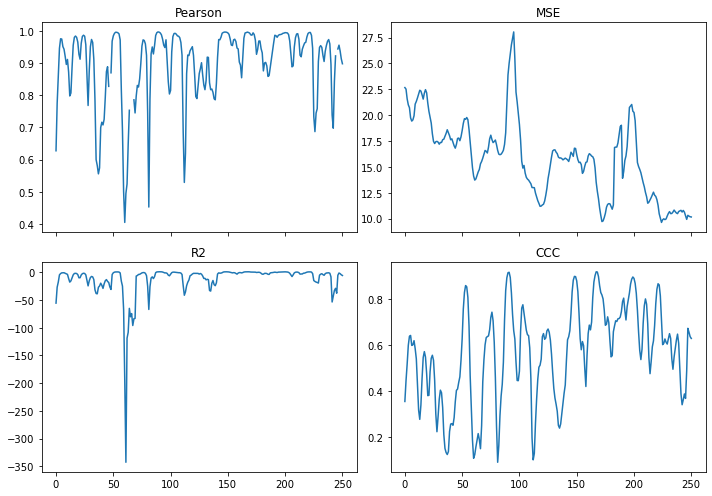

In [9]:
video_name = 'would_you_rather_29'
window_size_in_seconds = 0.3
window_size = round(window_size_in_seconds*24)
mapped_landmarks_df = landmarks_mapper(video_name)
windows = mapped_landmarks_df.rolling(window=window_size, center=True)
    
openface_landmarks = [f'x_{landmark_id}_openface' for landmark_id in range(17,68)]
mediapipe_landmarks = [f'x_{landmark_id}_mediapipe' for landmark_id in range(17,68)]

windowized_features = np.asarray([np.array([pearson(window), mse(window), r2(window), ccc(window)]) for window in windows])
windowized_pearson, windowized_mse, windowized_r2, windowized_ccc = windowized_features[:,0], windowized_features[:,1], windowized_features[:,2], windowized_features[:,3]
features=[windowized_pearson, windowized_mse, windowized_r2, windowized_ccc]

titles=['Pearson', 'MSE', 'R2', 'CCC']
fig, axes = plt.subplots(2,2, sharex=True, figsize=(10,7))
    
axes[0][0].plot(features[0])
axes[0][0].set_title(titles[0])

axes[0][1].plot(features[1])
axes[0][1].set_title(titles[1])

axes[1][0].plot(features[2])
axes[1][0].set_title(titles[2])

axes[1][1].plot(features[3])
axes[1][1].set_title(titles[3])
        
plt.tight_layout()
plt.show()

Dall'osservazione dei grafici delle quattro differenti metriche prese in considerazione, l'errore quadratico medio risulta essere quello più coerente con i risultati mostrati nei video elborati dai tool.
Per questo motivo abbiamo scelto di utilizzare questo parametro per la rilevazione di spezzoni di video problematici.
L'idea ora è quella di rilevare tutti queste criticità, rimuovere i dati falsati ed interpolarli.